## Predictive Analysis of Telecom Subscriber Churn

Churn in business refers to how many customers leave a company within a timeframe, often measured in subscription-based industries like telecommunications. It's crucial for companies to understand and analyze churn to boost customer retention and profitability.

In this project our aim is to
- Analyze and identify patterns among customers who churn, with a focus on common services or characteristics they share
- Additionally, we will implement various machine learning models and evaluate them on predicting this churn rate
- Dataset used https://www.kaggle.com/datasets/palashfendarkar/wa-fnusec-telcocustomerchurn
- This project has been inspired from this notebook https://www.kaggle.com/code/bandiatindra/telecom-churn-prediction/notebook done by Atindrabandi 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## I - Initial Data Exploration, an EDA Approach:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


First let's take a look at the distribution of our Target variable Churn

- In our data, 74% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

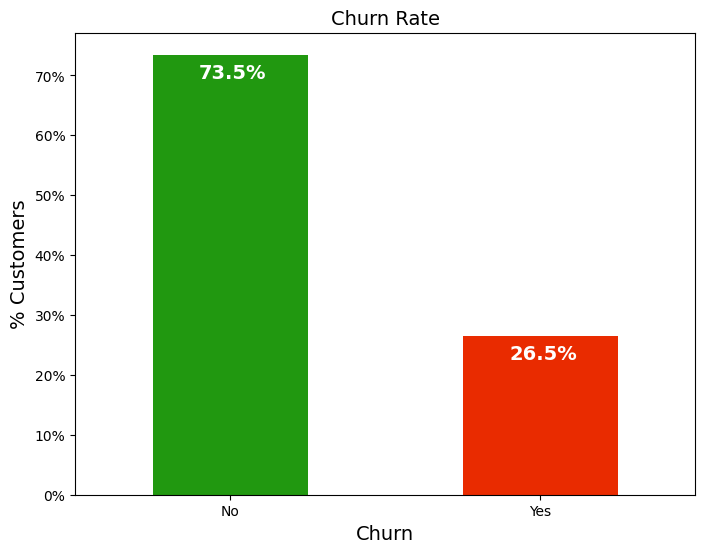

In [5]:
colors = ['#219810','#E92B00']
ax = (df['Churn'].value_counts()*100.0 /len(df)).plot(kind='bar', stacked = True, rot = 0, color = colors, figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            color='white', weight = 'bold', size = 14)

In [9]:
# let's see which columns we can transform to a binary numeric variable
for column in df.columns.values:
    print(column)
    print(df[column].unique())

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
['Female' 'Male']
SeniorCitizen
[0 1]
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaperlessBilling
['Yes' 'No']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

In [3]:
# 'gender' column has only two modalities (Male, Female)
# 'Partner', 'Dependents', 'PhoneService', 'OnlineBackup', 'PaperlessBilling', 'Churn' have also binary modalities (Yes, No)
# let's use mapping dictionaries for transformation

gender_mapping = {'Male': 1, 'Female': 0}
df['gender'] = df['gender'].map(gender_mapping)

boolean_mapping = {'Yes': 1, 'No': 0}
to_int_cols = ['Partner', 'Dependents', 'PhoneService', 'OnlineBackup', 'PaperlessBilling', 'Churn']
for col in to_int_cols:
    df[col] = df[col].map(boolean_mapping)


# Converting Total Charges to a numerical data type.
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

# Remove customer IDs
# df = df.drop('customerID', axis=1)

In [4]:
# Let's convert all the categorical variables into dummy variables


# first drop null variables
df2 = df.copy()
df2 = df2.drop('customerID', axis=1)
df2.dropna(inplace = True)

df_dummies = pd.get_dummies(df2)
df_dummies.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineBackup,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1.0,1,29.85,29.85,0,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0.0,0,56.95,1889.50,0,True,False,False,True,False,False,True,False,True,True,False,True,False,True,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1.0,1,53.85,108.15,1,True,False,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0.0,0,42.30,1840.75,0,False,True,False,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,0.0,1,70.70,151.65,1,True,False,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False


Let's take a quick look at the corelation between our target variable Churn and predictor ones

<Axes: >

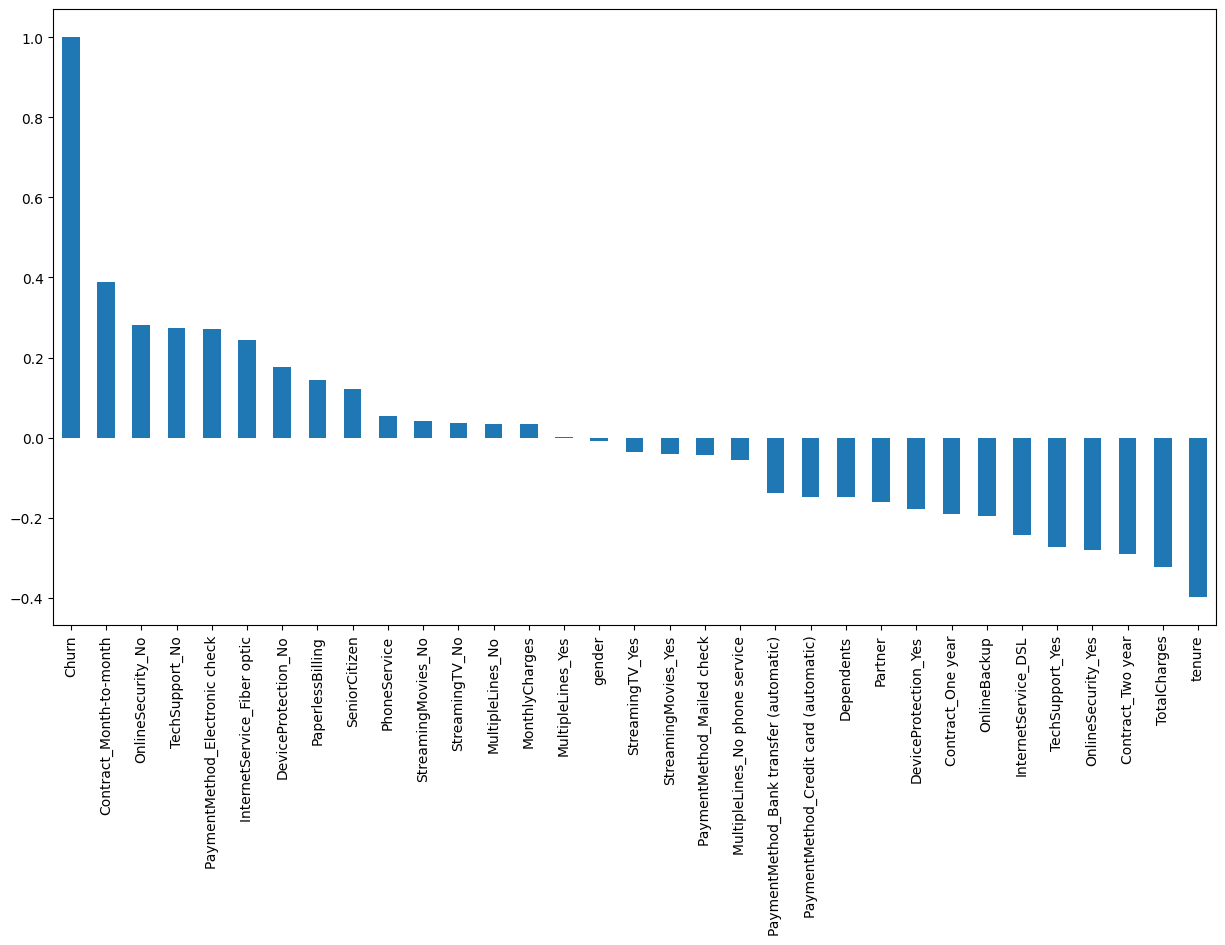

In [10]:
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

### Actionable Insights :

- we can see that churn rate is positivly correlated to contract_month_to_month_yes where contract_two_year is negatively corelated to it which means that customers with short-term contracts are more likely to churn compared to those with long-term contracts
    - Consider incentivizing customers to switch to longer-term contracts by improving their value proposition, offer discounts or additional services

- internet_service_fibre_optic customers having fibre optic service are more likely to churn
    - Investigate reasons behind dissatisfaction with this service such as speed, reliability, or pricing

- payment_method_electronic_check, customers using electronic check as their payment method are more likely to churn.
    - Investigate over the reason, there might be a service deficiency with this method

- online_security_no and tech_support_no variables are also positively corelated to churn rate

A.) Demographics - Let's first take a look on some distributions: the gender, age range, partner and dependent status of the customers


- For Gender distribution we can see that the gender variable is equally distributed in the dataset with 51% male and 49% female
- For Citizenship distribution, this variable is not balanced as only 16% are seniors and 83% are young people

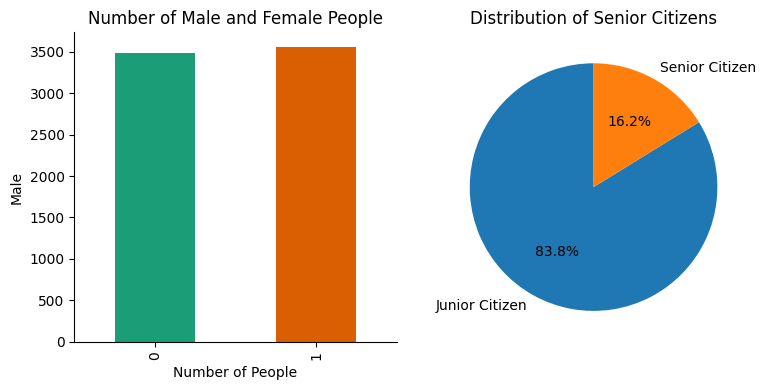

In [14]:
# Creating the subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# First subplot - Number of Male and Female People
df.groupby('gender').size().plot(kind='bar', color=sns.color_palette('Dark2'), ax=axes[0])
axes[0].set_title('Number of Male and Female People')
axes[0].set_xlabel('Number of People')
axes[0].set_ylabel('Male')
axes[0].spines[['top', 'right']].set_visible(False)

# Second subplot - Distribution of Senior Citizens
ax_pie = axes[1].pie(
    df['SeniorCitizen'].value_counts(), 
    labels=['Junior Citizen', 'Senior Citizen'], 
    autopct='%.1f%%',
    startangle=90)
axes[1].set_title('Distribution of Senior Citizens')

# Adjust subplot grid
fig.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.show()

- Partner and dependent status - About 50% of the customers have a partner, while only 30% of the total customers have dependents.

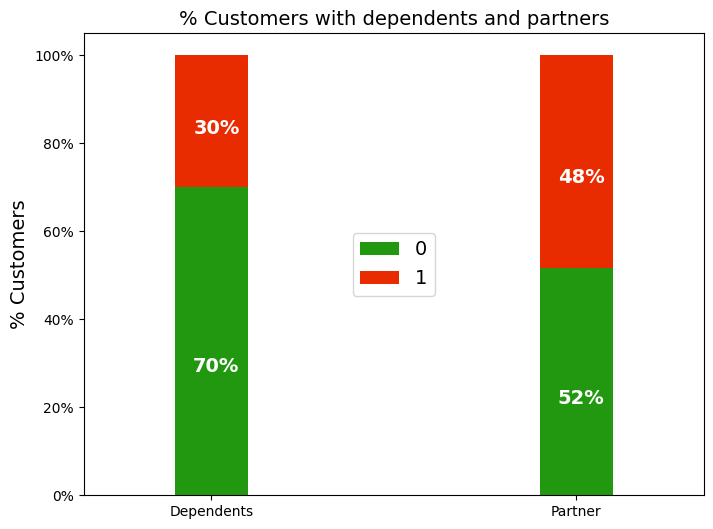

In [15]:
df2 = pd.melt(df, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(df)
colors = ['#219810','#E92B00']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

- Churn by contract type: as seen before one and two year contracts have lower numbers of leaving with only 11% and 3% churn % respectivly, while month to month contracts have 43% of churning

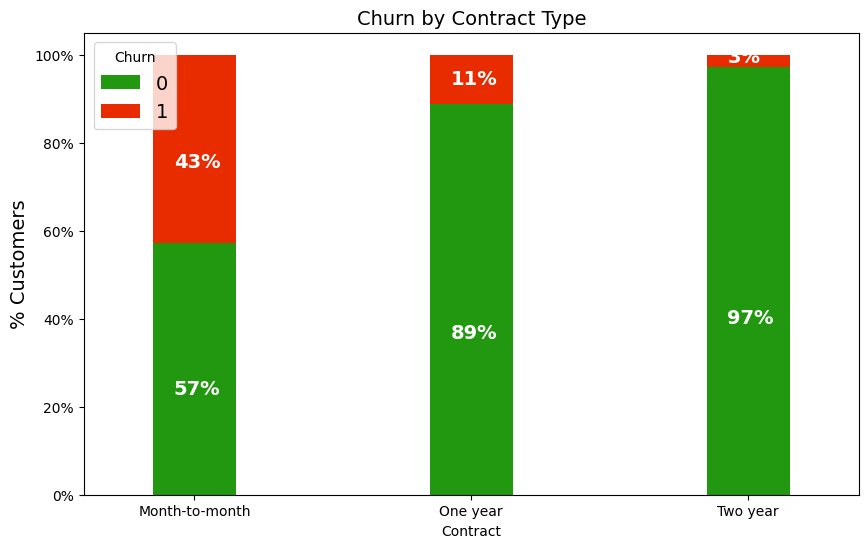

In [60]:
colors = ['#219810','#E92B00']
contract_churn = df.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

B.) Customer Account Information: Let's now look at the tenure, MonthlyCharges and contract type distributions

1. Tenure:
    - There is a significant drop in the number of customers after the first month. This indicates a high initial churn rate where many customers leave shortly after signing up
    - Customers with tenure between 10 to 60 months show a relatively flat distribution with a slight downward trend. It would be valuable to understand the factors affecting this group's retention and address any potential issues they face
    - At the upper end of the spectrum, there is a noticeable increase in the number of customers who stay longer (around 70 months or more). This indicates strong long-term retention, when a customer segment remains loyal over long periods

array([<Axes: title={'center': '# of Customers by their tenure'}, xlabel='Tenure (months)', ylabel='# of Customers'>,
       <Axes: title={'center': '# of Customers by Monthly charges'}, xlabel='Monthly Charges', ylabel='# of Customers'>],
      dtype=object)

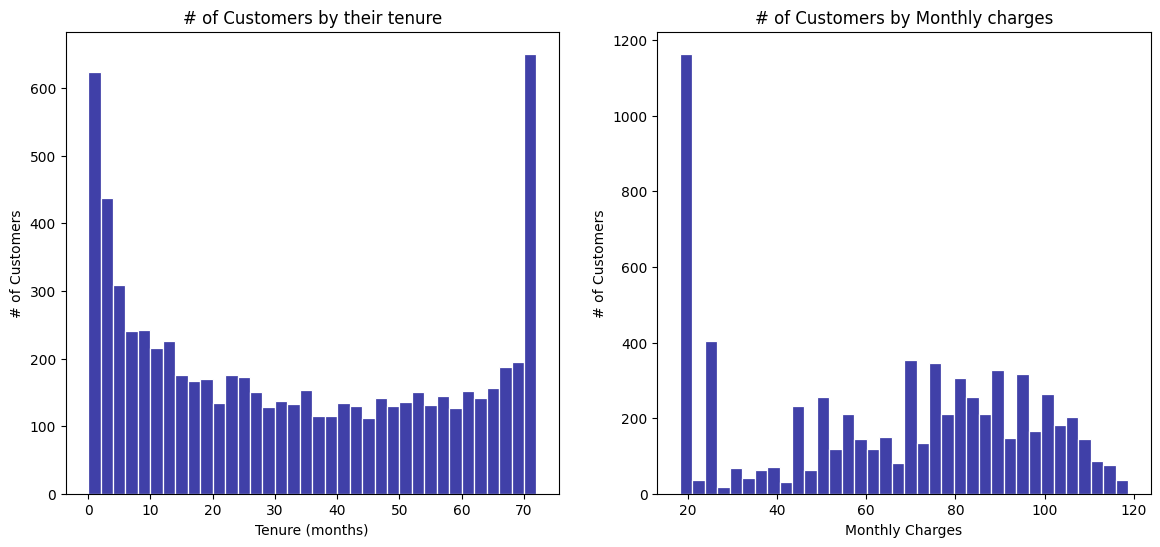

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Tenure
sns.histplot(df['tenure'], bins=int(180/5), color='darkblue', edgecolor='white', ax=axes[0])
axes[0].set_ylabel('# of Customers')
axes[0].set_xlabel('Tenure (months)')
axes[0].set_title('# of Customers by their tenure')

# Second plot: Monthly Charges
sns.histplot(df['MonthlyCharges'], bins=int(180/5), color='darkblue', edgecolor='white', ax=axes[1])
axes[1].set_ylabel('# of Customers')
axes[1].set_xlabel('Monthly Charges')
axes[1].set_title('# of Customers by Monthly charges')

axes

Tenure vs. Monthly Charges: let's use a scatter plot to see the relationship between tenure and monthly charges, colored by churn status
- we can see that the churners are mostly centralised when the tenure is between 0 and 20 and monthly charges is between 80 and 110 

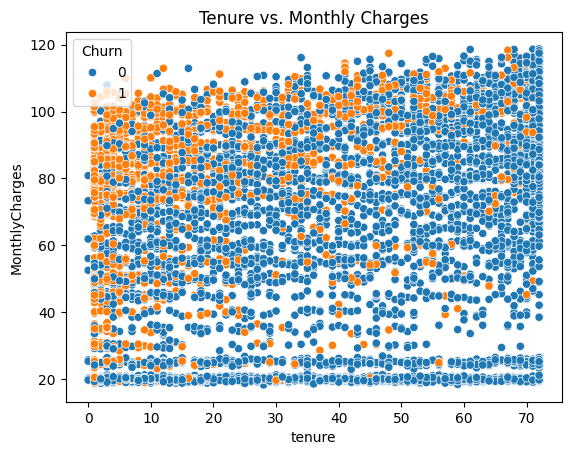

In [40]:
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df)
plt.title('Tenure vs. Monthly Charges')
plt.show()

2. Contracts: To understand the above graph, lets first look at the # of customers by different contracts.

    - As we can see from this graph most of the customers are in the month to month contract. While there are equal number of customers in the 1 year and 2 year contracts.

Text(0.5, 1.0, '# of Customers by Contract Type')

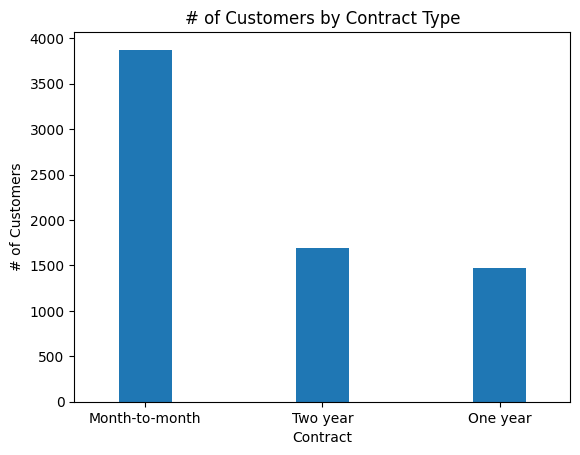

In [44]:
ax = df['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

3. Now let's look at the distribution of the tenure by contract type:

- Interestingly most of the monthly contracts last for 1-2 months, while the 2 year contracts tend to last for about 70 months. This shows that the customers taking a longer contract are more loyal to the company and tend to stay with it for a longer period of time.

- This is also what we saw in the earlier chart on correlation with the churn rate.

Text(0.5, 1.0, 'Two Year Contract')

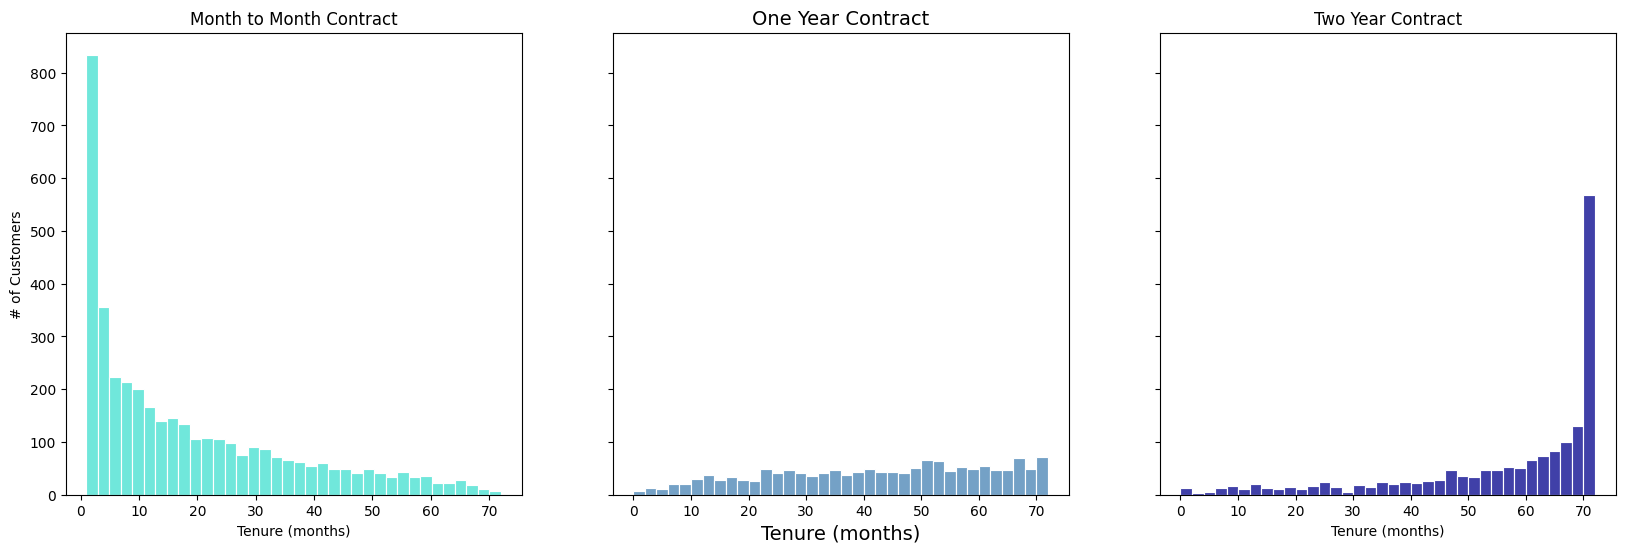

In [48]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.histplot(df[df['Contract']=='Month-to-month']['tenure'],
                   bins=int(180/5), color = 'turquoise',
                   edgecolor='white',
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.histplot(df[df['Contract']=='One year']['tenure'],
                   bins=int(180/5), color = 'steelblue',
                   edgecolor='white',
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.histplot(df[df['Contract']=='Two year']['tenure'],
                   bins=int(180/5), color = 'darkblue',
                   edgecolor='white',
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

4. Monthly Charges Distribution: let's now see the distribution of monthly charges to see if there's a correlation between higher charges and churn

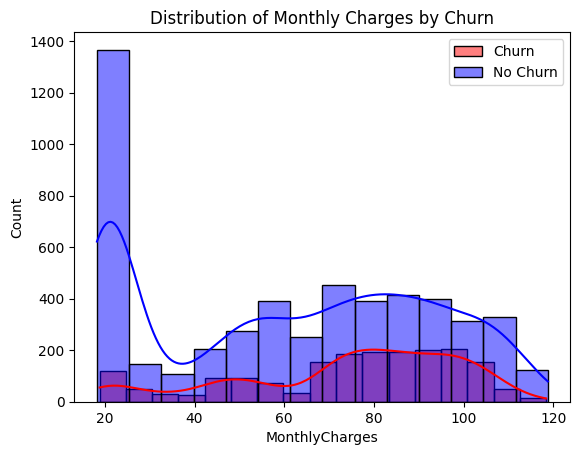

In [25]:
sns.histplot(df[df['Churn'] == 1]['MonthlyCharges'], kde=True, color='red', label='Churn')
sns.histplot(df[df['Churn'] == 0]['MonthlyCharges'], kde=True, color='blue', label='No Churn')
plt.title('Distribution of Monthly Charges by Churn')
plt.legend()
plt.show()

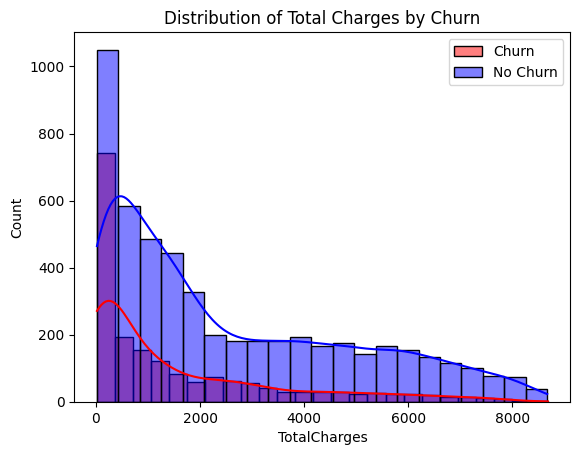

In [27]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
sns.histplot(df[df['Churn'] == 1]['TotalCharges'], kde=True, color='red', label='Churn')
sns.histplot(df[df['Churn'] == 0]['TotalCharges'], kde=True, color='blue', label='No Churn')
plt.title('Distribution of Total Charges by Churn')
plt.legend()
plt.show()

C. Let us now look at the distribution of various services used by customers

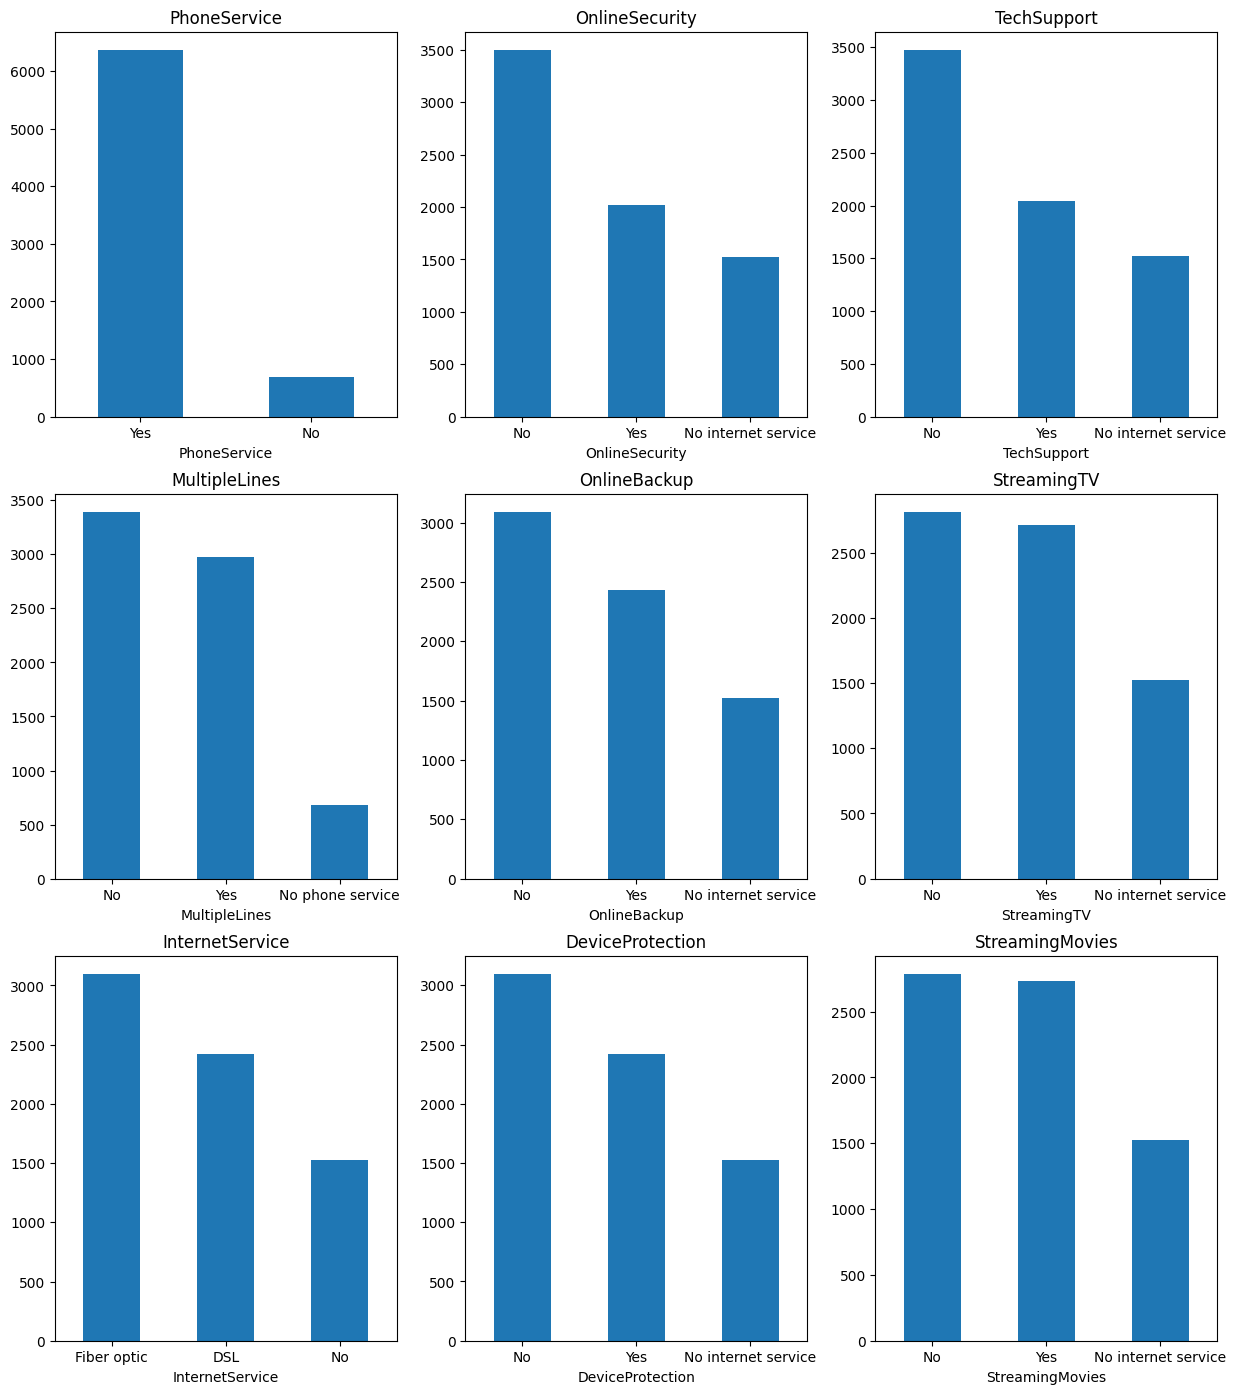

In [5]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,17))
for i, item in enumerate(services):
    if i < 3:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

## II - Predictive models and comparaison:
After going through the above EDA we will develop some predictive models and compare them. We will test Logistic Regression, Random Forest, SVM, ADA Boost and XG Boost

To compare our models we will use a confusion matrix since the accuracy is not enough, and this is because our data is imbalanced where we have 73% Of No churn and 27% of Yes churn. This metric will allow us to see in details how our model is performing like true positives (TP), true negatives (TN), false positives (FP) and false negatives (FN)

One thing to keep in mind, in some applications, false positives and false negatives have different costs. For example, in medical diagnosis, failing to identify a disease (false negative) may be more costly than a false alarm (false positive). In our case, failing to identify a churning subscriber (false negative) is more costly than failing to identify a staying one (false positive) which is why FN will have a bit more consideration that FP in our comparison.

In [5]:
# plot_confusion_matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model_name, y_test, preds):
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No', 'Yes'], 
                yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

### 1. Logistic Regression

In [6]:
from sklearn.preprocessing import MinMaxScaler
# each model has its fitting scaling method, we'll use MinMaxScaler, it'll scale all the variables to a range of 0 to 1
# an interesting article to refer to pic a scaling method
# https://medium.com/@megha.natarajan/mastering-data-scaling-techniques-visualizations-and-insights-a00b2cb422c2

# We will use the data frame where we had created dummy variables
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineBackup,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,1.0,0.067156,0.000739,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.464789,1.0,0.0,0.0,0.351522,0.215446,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.014085,1.0,1.0,1.0,0.318993,0.009779,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.619718,0.0,0.0,0.0,0.197796,0.209817,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.014085,1.0,0.0,1.0,0.495803,0.014801,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Split the data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_train.head()

model = LogisticRegression()
result = model.fit(X_train, y_train)

# Make the prediction and print accuracy
prediction = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, prediction)
df_compar = pd.DataFrame({
    'y_test': y_test,
    'prediction': prediction
})

print(f"accuracy: {accuracy}")
df_compar.head()

accuracy: 0.7738814993954051


,y_test,prediction
0,0,0
1,0,1
2,0,0
3,1,0
4,0,0


Let's plot the weights of variables contributing to the prediction

- To confirm our EDA, Tenure and contract_2_years, internetService_DSL are negatively corelated with Churn which means the likeliness of churn decreases with these variables
- Where totalCharges, month_to_month_contract, InternetService_optic_fibre, PaperlessBilling are positively correlated with it

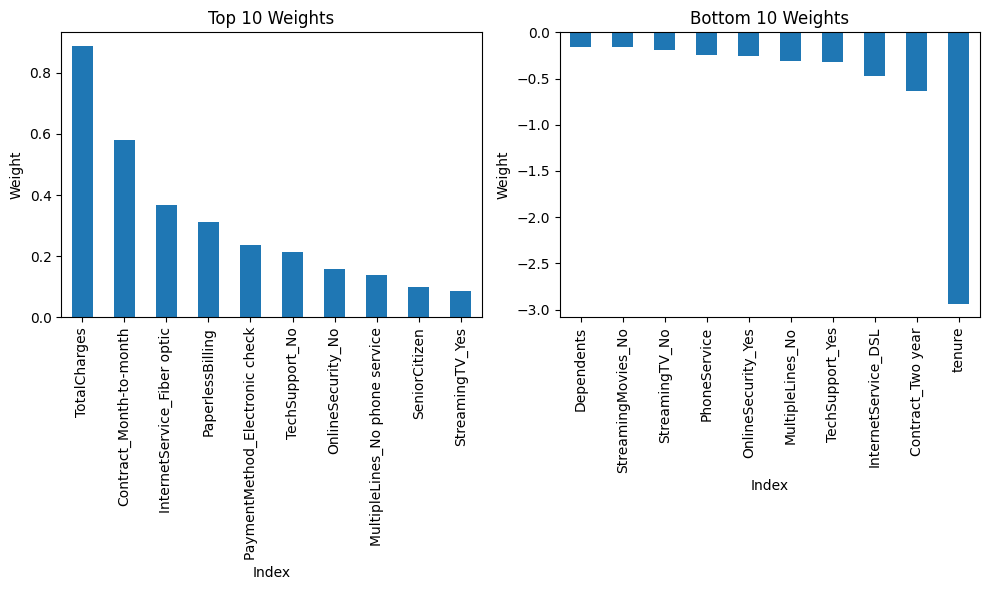

In [47]:
import matplotlib.pyplot as plt

weights = pd.Series(model.coef_[0], index=X.columns.values)

top_10 = weights.sort_values(ascending=False)[:10]
bottom_10 = weights.sort_values(ascending=False)[-10:]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Plot top 10 weights
top_10.plot(kind='bar', ax=axes[0], title='Top 10 Weights')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Weight')

# Plot bottom 10 weights
bottom_10.plot(kind='bar', ax=axes[1], title='Bottom 10 Weights')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Weight')

plt.tight_layout()
plt.show()


In [59]:
values, counts = np.unique(y_test, return_counts=True)
values, counts

(array([0, 1]), array([1138,  516]))

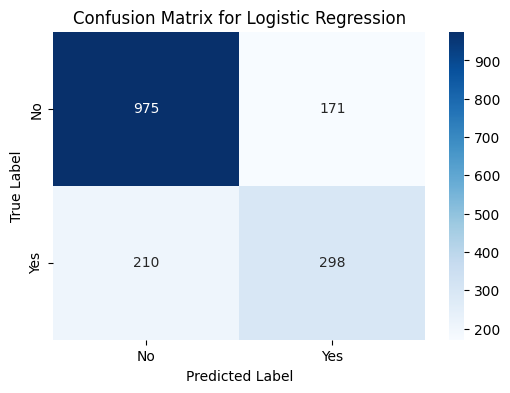

In [17]:
plot_confusion_matrix("Logistic Regression", y_test, prediction)

### 2. Random Forest

Now random forest. When comparing the two confusion matrices we can see that:
- Random Forest and Logistic Regression had more or less the same score at determining True Negatives, where they had 971 and 969 True negatives respectively
- Logistic Regression did better in predicting True positives, where it had 311 and only 267 for Random Forest
- Now for the missclassifications, they both had about the same False Positives but when it comes to False Negatives, Logistic Regression did quite better with a difference of 44 less missclassification
- Overall we can say that Logistic regression performed better since it was more accurate at determining True Positives but it also had less missclassifications on False Negatives.

accuracy: 0.7484885126964933


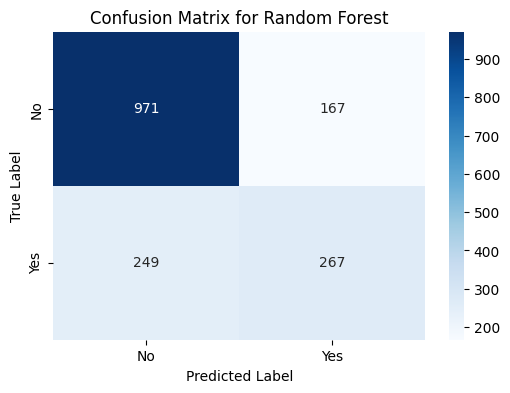

In [9]:
from sklearn.ensemble import RandomForestClassifier
# next test grid search

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state=50, max_features = 0.3,
                                  max_depth=70) # max_leaf_nodes = 30,
model_rf.fit(X_train, y_train)

prediction = model_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, prediction)
print(f"accuracy: {accuracy}")
plot_confusion_matrix("Random Forest", y_test, prediction)
# max_features
# sqrt 0.7606527651858568
# 0.3 0.7633726201269265

# max_leaf_nodes: limit on the splitting the node and thus helps to reduce the depth of the tree
# big -> overfitting
# small -> underfitting
# 30 0.7633726201269265
# 25 0.7624660018132366

- From random forest algorithm, TotalCharges, Monthly charges and tenure are the most important predictor variables to predict churn
- The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA

<Axes: >

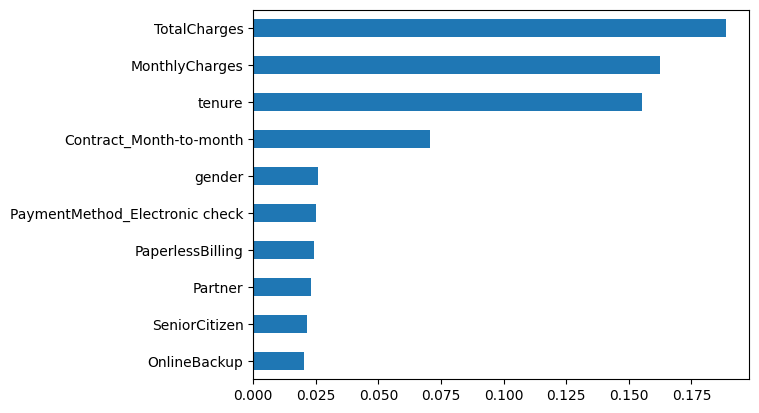

In [14]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

### 3. Support Vector Machine (SVM)

Now comparing SVM to Logistic Regression, SVM is doing slighly better with 318 TP and only 298 for LR, it also had a bit less FN, 198 to 210

accuracy: 0.7696493349455864


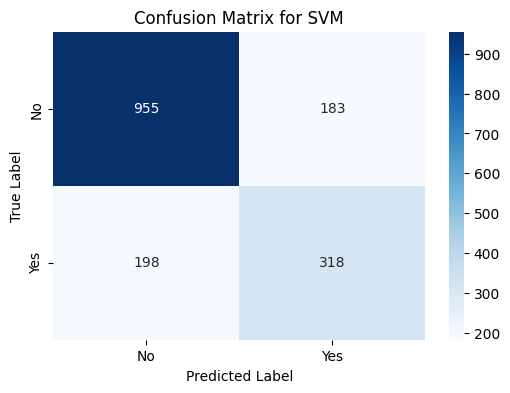

In [18]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
model.svm = SVC(kernel='linear') 

model.svm.fit(X_train,y_train)
prediction = model.svm.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, prediction)
print(f"accuracy:", accuracy_score)
plot_confusion_matrix("SVM", y_test, prediction)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1146
           1       0.64      0.59      0.61       508

    accuracy                           0.77      1654
   macro avg       0.73      0.72      0.72      1654
weighted avg       0.77      0.77      0.77      1654



### 4. ADA Boost

It had the same performance as as SVM.

c:\Users\client\Desktop\projects\churn-pred-telecom\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.7696493349455864


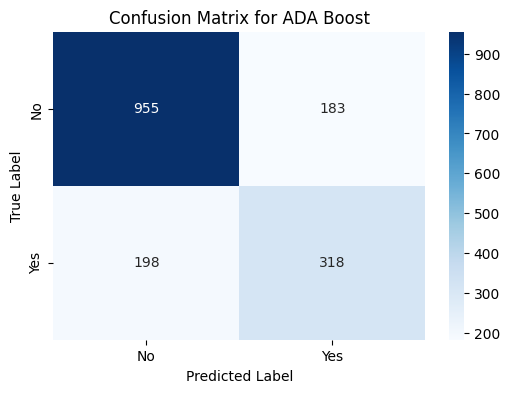

In [20]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
model.fit(X_train,y_train)
preds = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)
plot_confusion_matrix("ADA Boost", y_test, prediction)

### 5. XG Boost

Comparing to SVM. It was less performant with less TP and more FN

Accuracy: 0.74546553808948


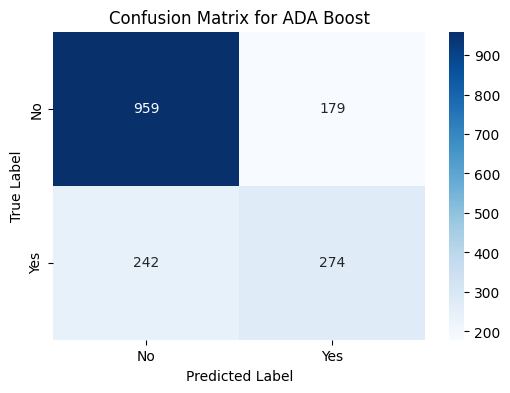

In [23]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)
plot_confusion_matrix("ADA Boost", y_test, prediction)

### .

There are more metrics we can use to measure the models' performance and compare them such as Precision (Sensitivity), Recall (Specificity), F1 Score, Area Under the ROC Curve (AUC-ROC)